**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)
#start_spark(executor_instances=4, executor_cores=4, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.app.startTime,1717719526227
spark.ui.port,4473
spark.sql.warehouse.dir,file:/users/home/dcp31/assignment_2/spark-warehouse
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.app.name,dcp31 (jupyter)
spark.executor.id,driver
spark.app.id,app-20240607121847-1444


In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [4]:
# functions from CreditCardFraud notebook

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().orderBy("label").toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')
    
def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

### Question 1 (a)

In [5]:
# From help session 3
# Choose a dataset name, load attribute names, and define schemas based on attribute names

name = 'msd-jmir-spectral-all-all-v1.0'

metadata_schema = StructType([
    StructField("name", StringType()),
    StructField("type", StringType()),
])
metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv', schema=metadata_schema)

show_as_html(metadata)

,name,type
0,Spectral_Centroid_Overall_Standard_Deviation_1,real
1,Spectral_Rolloff_Point_Overall_Standard_Deviat...,real
2,Spectral_Flux_Overall_Standard_Deviation_1,real
3,Compactness_Overall_Standard_Deviation_1,real
4,Spectral_Variability_Overall_Standard_Deviation_1,real
5,Root_Mean_Square_Overall_Standard_Deviation_1,real
6,Fraction_Of_Low_Energy_Windows_Overall_Standar...,real
7,Zero_Crossings_Overall_Standard_Deviation_1,real
8,Spectral_Centroid_Overall_Average_1,real
9,Spectral_Rolloff_Point_Overall_Average_1,real


In [6]:
# From help session 3
# simple_schema selected for readability

schema_simple = StructType([
    StructField(f"F{i:03d}", DoubleType(), True) for i in range(0, metadata.count() - 1)
] + [
    StructField(f"track_id", StringType(), True)
])

audio_features = spark.read.csv(f'/data/msd/audio/features/{name}.csv', schema=schema_simple, quote="'")

show_as_html(audio_features)

,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,track_id
0,7.928,0.07893,0.001245,222.2,0.001429,0.05438,0.05324,22.350,12.810,0.09207,0.000914,1682.0,0.003026,0.11990,0.5313,38.15,TRHFHQZ12903C9E2D5
1,8.501,0.07007,0.005855,200.6,0.003042,0.09163,0.05096,21.180,7.432,0.05245,0.003384,1570.0,0.004289,0.15320,0.5988,25.07,TRHFHYX12903CAF953
2,5.101,0.04946,0.007952,241.3,0.002879,0.08716,0.03366,13.130,9.995,0.07575,0.010310,1455.0,0.008896,0.34040,0.5227,34.82,TRHFHAU128F9341A0E
3,8.101,0.06402,0.002458,238.5,0.002335,0.08902,0.06764,18.710,15.350,0.10200,0.001901,1712.0,0.004152,0.16490,0.5467,41.47,TRHFHLP128F14947A7
4,7.226,0.05985,0.005215,194.7,0.002057,0.05784,0.04056,15.880,12.980,0.10940,0.008331,1595.0,0.008042,0.30870,0.5067,39.75,TRHFHFF128F930AC11
5,4.304,0.03282,0.001262,279.3,0.002383,0.08844,0.07417,10.880,7.721,0.04463,0.001093,1778.0,0.004259,0.16220,0.5364,18.54,TRHFHYJ128F4234782
6,2.724,0.02075,0.001779,203.1,0.001305,0.04530,0.05082,9.718,5.263,0.02806,0.000893,1748.0,0.002865,0.10780,0.5391,19.30,TRHFHHR128F9339010
7,15.660,0.09097,0.000516,178.1,0.001069,0.03922,0.08063,33.940,9.158,0.05251,0.000295,1621.0,0.001542,0.05869,0.5568,23.59,TRHFHMB128F4213BC9
8,2.161,0.01658,0.003491,239.0,0.001800,0.05721,0.04387,7.207,3.613,0.02298,0.002387,1676.0,0.004306,0.15850,0.5359,10.82,TRHFHWT128F429032D
9,8.862,0.07809,0.005187,218.2,0.003705,0.11180,0.05035,23.790,7.212,0.05154,0.003541,1547.0,0.006084,0.21200,0.5540,24.34,TRHFHKO12903CBAF09


In [19]:
print(audio_features.count())

994623


In [84]:
# compute descriptive statistics
id = "track_id"

# create list of feature column names exlcuding track_id variable
feature_cols = [column for column in audio_features.columns if column != id]

# for the cols in feature_cols, compute descriptive stats
desc_stats = audio_features.select(feature_cols).describe()

show_as_html(desc_stats)

,summary,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,6.945080738480859,0.055706619550723833,0.003945426548426958,222.51777541026038,0.0022271423235684933,0.07420125646818831,0.06020736022995611,16.802865692749933,9.110254059807659,0.06194319533235132,0.002932152349630344,1638.7320529451026,0.004395477754344122,0.16592787308504786,0.55628320208672,26.680411300033235
2,stddev,3.6317955553970953,0.026500155164317668,0.003265325935538864,59.72621371192979,0.001039740286439188,0.031766186853395606,0.018516474403617193,7.530118067018106,3.8436309603666485,0.02901668750360531,0.0024911471268951654,106.10606646605186,0.001995888300231308,0.07429851374658551,0.047553705701117825,10.394715710580604
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,73.31,0.3739,0.07164,10290.0,0.01256,0.3676,0.4938,141.6,133.0,0.7367,0.07549,24760.0,0.02366,0.8564,0.9538,280.5


In [8]:
# the way from CreditCardFraud notebook
# compute descriptive statistics
# easier to read

statistics = (
    audio_features
    .select([col for col in audio_features.columns if col.startswith("F")])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(statistics)

,index,count,mean,stddev,min,max
0,F000,994623,6.945080738480858,3.6317955553970953,0.0,73.31
1,F001,994623,0.055706619550723833,0.026500155164317668,0.0,0.3739
2,F002,994623,0.003945426548426958,0.003265325935538864,0.0,0.07164
3,F003,994623,222.51777541026038,59.726213711929795,0.0,10290.0
4,F004,994623,0.0022271423235684937,0.001039740286439188,0.0,0.01256
5,F005,994623,0.07420125646818831,0.031766186853395606,0.0,0.3676
6,F006,994623,0.06020736022995612,0.018516474403617193,0.0,0.4938
7,F007,994623,16.802865692749933,7.530118067018105,0.0,141.6
8,F008,994623,9.110254059807659,3.8436309603666485,0.0,133.0
9,F009,994623,0.06194319533235132,0.02901668750360531,0.0,0.7367


In [85]:
# investigate correlations

# use VectorAssembler to combine all features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(audio_features).select("features")

# compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0] # pearson is default

# convert to a numpy array and display
correlation_matrix_array = correlation_matrix.toArray()
print(correlation_matrix_array)

[[ 1.          0.95460979  0.26350509  0.03911345  0.34039383  0.36411773
   0.1102377   0.97155969  0.6237086   0.59024421  0.14097994 -0.14027305
   0.05139729  0.0505316   0.15038292  0.62020265]
 [ 0.95460979  1.          0.30834922 -0.01946967  0.36309911  0.38116765
   0.03354404  0.97134878  0.59390558  0.59177888  0.20299051 -0.16797191
   0.12368312  0.12595478  0.17023905  0.65261468]
 [ 0.26350509  0.30834922  1.         -0.01402115  0.9000568   0.86682244
  -0.16510522  0.30876726  0.02690208  0.07110027  0.89180573 -0.25553293
   0.78960186  0.76673109  0.21404173  0.14142359]
 [ 0.03911345 -0.01946967 -0.01402115  1.          0.04586105  0.05839113
   0.30968871  0.00827667 -0.07593269 -0.10783183 -0.06649403  0.30508171
  -0.07267719 -0.08596734 -0.06281884 -0.15375335]
 [ 0.34039383  0.36309911  0.9000568   0.04586105  1.          0.98466137
  -0.06753273  0.38927696 -0.01356341  0.0081332   0.77460834 -0.21043109
   0.75734036  0.72222541  0.14808205  0.07300475]
 [ 0.

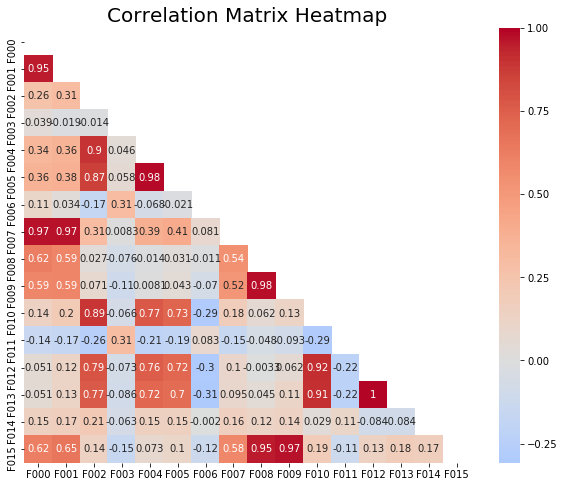

In [10]:
# convert the numpy array to a Pandas dataframe for visualisation
correlation_df = pd.DataFrame(correlation_matrix_array, index=feature_cols, columns=feature_cols)

# display only the lower half
mask = np.triu(np.ones_like(correlation_df, dtype=bool))

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.show()

In [11]:
# from notebook

assembler = VectorAssembler(
    inputCols=[col for col in audio_features.columns if col.startswith("F")],
    outputCol="features"
)

data = assembler.transform(audio_features)

show_as_html(data)

correlations = Correlation.corr(data, 'features', 'pearson').collect()[0][0].toArray()  # from Spark's output to numpy array

,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,track_id,features
0,7.928,0.07893,0.001245,222.2,0.001429,0.05438,0.05324,22.350,12.810,0.09207,0.000914,1682.0,0.003026,0.11990,0.5313,38.15,TRHFHQZ12903C9E2D5,"[7.928, 0.07893, 0.001245, 222.2, 0.001429, 0...."
1,8.501,0.07007,0.005855,200.6,0.003042,0.09163,0.05096,21.180,7.432,0.05245,0.003384,1570.0,0.004289,0.15320,0.5988,25.07,TRHFHYX12903CAF953,"[8.501, 0.07007, 0.005855, 200.6, 0.003042, 0...."
2,5.101,0.04946,0.007952,241.3,0.002879,0.08716,0.03366,13.130,9.995,0.07575,0.010310,1455.0,0.008896,0.34040,0.5227,34.82,TRHFHAU128F9341A0E,"[5.101, 0.04946, 0.007952, 241.3, 0.002879, 0...."
3,8.101,0.06402,0.002458,238.5,0.002335,0.08902,0.06764,18.710,15.350,0.10200,0.001901,1712.0,0.004152,0.16490,0.5467,41.47,TRHFHLP128F14947A7,"[8.101, 0.06402, 0.002458, 238.5, 0.002335, 0...."
4,7.226,0.05985,0.005215,194.7,0.002057,0.05784,0.04056,15.880,12.980,0.10940,0.008331,1595.0,0.008042,0.30870,0.5067,39.75,TRHFHFF128F930AC11,"[7.226, 0.05985, 0.005215, 194.7, 0.002057, 0...."
5,4.304,0.03282,0.001262,279.3,0.002383,0.08844,0.07417,10.880,7.721,0.04463,0.001093,1778.0,0.004259,0.16220,0.5364,18.54,TRHFHYJ128F4234782,"[4.304, 0.03282, 0.001262, 279.3, 0.002383, 0...."
6,2.724,0.02075,0.001779,203.1,0.001305,0.04530,0.05082,9.718,5.263,0.02806,0.000893,1748.0,0.002865,0.10780,0.5391,19.30,TRHFHHR128F9339010,"[2.724, 0.02075, 0.001779, 203.1, 0.001305, 0...."
7,15.660,0.09097,0.000516,178.1,0.001069,0.03922,0.08063,33.940,9.158,0.05251,0.000295,1621.0,0.001542,0.05869,0.5568,23.59,TRHFHMB128F4213BC9,"[15.66, 0.09097, 0.0005162, 178.1, 0.001069, 0..."
8,2.161,0.01658,0.003491,239.0,0.001800,0.05721,0.04387,7.207,3.613,0.02298,0.002387,1676.0,0.004306,0.15850,0.5359,10.82,TRHFHWT128F429032D,"[2.161, 0.01658, 0.003491, 239.0, 0.0018, 0.05..."
9,8.862,0.07809,0.005187,218.2,0.003705,0.11180,0.05035,23.790,7.212,0.05154,0.003541,1547.0,0.006084,0.21200,0.5540,24.34,TRHFHKO12903CBAF09,"[8.862, 0.07809, 0.005187, 218.2, 0.003705, 0...."


In [12]:
# from notebook
# choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(HTML(pd.DataFrame(correlations.round(2)).to_html(max_cols=30)))
display(HTML(pd.DataFrame(correlations > threshold).astype(int).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.00,0.95,0.26,0.04,0.34,0.36,0.11,0.97,0.62,0.59,0.14,-0.14,0.05,0.05,0.15,0.62
1,0.95,1.00,0.31,-0.02,0.36,0.38,0.03,0.97,0.59,0.59,0.20,-0.17,0.12,0.13,0.17,0.65
2,0.26,0.31,1.00,-0.01,0.90,0.87,-0.17,0.31,0.03,0.07,0.89,-0.26,0.79,0.77,0.21,0.14
3,0.04,-0.02,-0.01,1.00,0.05,0.06,0.31,0.01,-0.08,-0.11,-0.07,0.31,-0.07,-0.09,-0.06,-0.15
4,0.34,0.36,0.90,0.05,1.00,0.98,-0.07,0.39,-0.01,0.01,0.77,-0.21,0.76,0.72,0.15,0.07
5,0.36,0.38,0.87,0.06,0.98,1.00,-0.02,0.41,0.03,0.04,0.73,-0.19,0.72,0.70,0.15,0.10
6,0.11,0.03,-0.17,0.31,-0.07,-0.02,1.00,0.08,-0.01,-0.07,-0.29,0.08,-0.30,-0.31,-0.00,-0.12
7,0.97,0.97,0.31,0.01,0.39,0.41,0.08,1.00,0.54,0.52,0.18,-0.15,0.10,0.09,0.16,0.58
8,0.62,0.59,0.03,-0.08,-0.01,0.03,-0.01,0.54,1.00,0.98,0.06,-0.05,-0.00,0.04,0.12,0.95
9,0.59,0.59,0.07,-0.11,0.01,0.04,-0.07,0.52,0.98,1.00,0.13,-0.09,0.06,0.11,0.14,0.97


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


### Question 1 (b)

In [7]:
# load MAGD data

genre_schema = StructType([
        StructField("track_id", StringType()),
        StructField("genre", StringType()),
    ])

genres = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "true")
    .option("sep", "\t")
    .schema(genre_schema)
    .load("hdfs:////data/msd/genre/msd-MAGD-genreAssignment.tsv")
)

show_as_html(genres)

,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock
5,TRAAADT12903CCC339,Easy_Listening
6,TRAAAED128E0783FAB,Vocal
7,TRAAAEF128F4273421,Pop_Rock
8,TRAAAEM128F93347B9,Electronic
9,TRAAAFD128F92F423A,Pop_Rock


In [14]:
# count unique tracks

print(genres.select(F.col("track_id")).distinct().count())                           

422714


In [15]:
# count rows

print(genres.count())

422714


In [16]:
# count tracks per genre
genre_count = (
    genres.groupBy("genre")
    .agg(F.countDistinct(F.col("track_id")).alias("count"))
    .orderBy(F.desc("count"))
)

show_as_html(genre_count, 50)

,genre,count
0,Pop_Rock,238786
1,Electronic,41075
2,Rap,20939
3,Jazz,17836
4,Latin,17590
5,RnB,14335
6,International,14242
7,Country,11772
8,Religious,8814
9,Reggae,6946


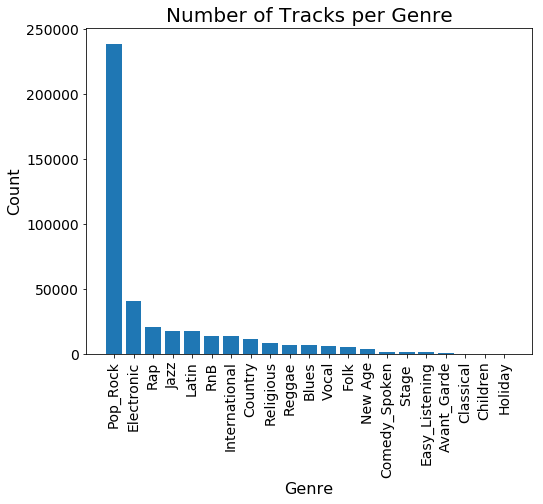

In [18]:
# visualise tracks per genre
genre_count = genre_count.toPandas()

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(genre_count["genre"], genre_count["count"])
ax.set_xlabel('Genre', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Number of Tracks per Genre', fontsize=20)
plt.xticks(rotation=90)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

### Question 1 (c)

In [8]:
# inner join audio features and genres on track_id so all remaining tracks have a genre

audio_features = audio_features.join(genres, "track_id", "inner")
show_as_html(audio_features, 10)

,track_id,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre
0,TRAAABD128F429CF47,6.229,0.05340,0.001519,172.5,0.001557,0.05665,0.05580,16.23,9.114,0.06159,0.001090,1626.0,0.002902,0.11260,0.5304,27.00,Pop_Rock
1,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.03,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.96,Pop_Rock
2,TRAAHAU128F9313A3D,6.099,0.05708,0.000868,187.9,0.000959,0.03320,0.06616,15.04,12.020,0.09123,0.000864,1569.0,0.002507,0.09907,0.5874,35.99,Pop_Rock
3,TRAAHZP12903CA25F4,11.180,0.07767,0.002841,265.3,0.002088,0.07393,0.06671,24.03,18.560,0.11150,0.000962,1636.0,0.002193,0.08333,0.6052,44.33,Rap
4,TRAAICW128F1496C68,3.433,0.03825,0.002125,185.2,0.001619,0.05383,0.05024,10.48,6.082,0.04126,0.001649,1617.0,0.003661,0.13810,0.5431,22.45,International
5,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.04,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.20,Pop_Rock
6,TRAAMHG128F92ED7B2,6.322,0.04798,0.002646,249.9,0.002276,0.08219,0.05741,15.50,10.370,0.06651,0.002537,1730.0,0.005004,0.19340,0.4740,29.26,International
7,TRAAROH128F42604B0,11.260,0.08735,0.003288,224.9,0.002591,0.08610,0.05426,27.61,8.213,0.05741,0.002075,1651.0,0.003718,0.13360,0.6163,26.16,Electronic
8,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.22,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.54,Reggae
9,TRAAUQF12903CC4A4D,13.970,0.10600,0.000500,190.1,0.001398,0.05153,0.08422,32.86,8.139,0.04900,0.000379,1675.0,0.002373,0.09006,0.5145,25.32,Pop_Rock


In [21]:
# count remaining tracks
print(audio_features.count())

420620


### Question 2 (b)
### Binary classification

In [9]:
# encode the 'genre' column
df = audio_features.withColumn("label", F.when(audio_features["genre"] == "Electronic", 1).otherwise(0))

show_as_html(df, 10)

,track_id,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre,label
0,TRAAABD128F429CF47,6.229,0.05340,0.001519,172.5,0.001557,0.05665,0.05580,16.23,9.114,0.06159,0.001090,1626.0,0.002902,0.11260,0.5304,27.00,Pop_Rock,0
1,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.03,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.96,Pop_Rock,0
2,TRAAHAU128F9313A3D,6.099,0.05708,0.000868,187.9,0.000959,0.03320,0.06616,15.04,12.020,0.09123,0.000864,1569.0,0.002507,0.09907,0.5874,35.99,Pop_Rock,0
3,TRAAHZP12903CA25F4,11.180,0.07767,0.002841,265.3,0.002088,0.07393,0.06671,24.03,18.560,0.11150,0.000962,1636.0,0.002193,0.08333,0.6052,44.33,Rap,0
4,TRAAICW128F1496C68,3.433,0.03825,0.002125,185.2,0.001619,0.05383,0.05024,10.48,6.082,0.04126,0.001649,1617.0,0.003661,0.13810,0.5431,22.45,International,0
5,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.04,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.20,Pop_Rock,0
6,TRAAMHG128F92ED7B2,6.322,0.04798,0.002646,249.9,0.002276,0.08219,0.05741,15.50,10.370,0.06651,0.002537,1730.0,0.005004,0.19340,0.4740,29.26,International,0
7,TRAAROH128F42604B0,11.260,0.08735,0.003288,224.9,0.002591,0.08610,0.05426,27.61,8.213,0.05741,0.002075,1651.0,0.003718,0.13360,0.6163,26.16,Electronic,1
8,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.22,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.54,Reggae,0
9,TRAAUQF12903CC4A4D,13.970,0.10600,0.000500,190.1,0.001398,0.05153,0.08422,32.86,8.139,0.04900,0.000379,1675.0,0.002373,0.09006,0.5145,25.32,Pop_Rock,0


In [23]:
# check class distribution

counts = df.groupby('label').count().orderBy('label')
show_as_html(counts)

,label,count
0,0,379954
1,1,40666


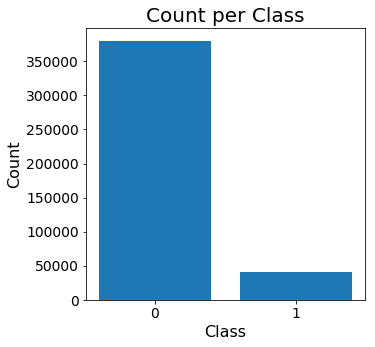

In [24]:
# visualise class distribution

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count per Class', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

### Question 2 (c)

In [10]:
# exclude 'id', genre' and 'label' columns from features

feature_cols = df.columns[1:-3]  
print(feature_cols) # check it worked correctly

['F000', 'F001', 'F002', 'F003', 'F004', 'F005', 'F006', 'F007', 'F008', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014']


In [11]:
# create vector of features 

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", "label")

show_as_html(assembled_df)

,features,label
0,"[6.229, 0.0534, 0.001519, 172.5, 0.001557, 0.0...",0
1,"[5.699, 0.03838, 0.001236, 274.8, 0.001789, 0....",0
2,"[6.099, 0.05708, 0.0008682, 187.9, 0.0009592, ...",0
3,"[11.18, 0.07767, 0.002841, 265.3, 0.002088, 0....",0
4,"[3.433, 0.03825, 0.002125, 185.2, 0.001619, 0....",0
5,"[3.267, 0.02975, 0.005098, 234.2, 0.002431, 0....",0
6,"[6.322, 0.04798, 0.002646, 249.9, 0.002276, 0....",0
7,"[11.26, 0.08735, 0.003288, 224.9, 0.002591, 0....",1
8,"[13.68, 0.09743, 0.004568, 253.5, 0.002828, 0....",0
9,"[13.97, 0.106, 0.0004996, 190.1, 0.001398, 0.0...",0


In [12]:
# from CreditCardFraud notebook
# Exact stratification using Window (binary, counts hard coded)

temp = (
    assembled_df
    .withColumn("num", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379954 * 0.8)) |
    ((F.col("label") == 1) & (F.col("row") < 40666 * 0.8))
)
training.cache()

test = temp.join(training, on="num", how="left_anti")
test.cache()

training = training.drop("num", "random", "row")
test = test.drop("num", "random", "row")

In [13]:
print_class_balance(assembled_df, "assembled_df")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: assembled_df
total:   420620
counts:
   label   count     ratio
0      0  379954  0.903319
1      1   40666  0.096681

dataset: training
total:   336495
counts:
   label   count     ratio
0      0  303963  0.903321
1      1   32532  0.096679

dataset: test
total:   84125
counts:
   label  count     ratio
0      0  75991  0.903311
1      1   8134  0.096689



#### Resampling

In [14]:
# Ensure datasets are cached
assembled_df.cache()
training.cache()
test.cache()

DataFrame[features: vector, label: int]

,label,count
0,0,303963
1,1,32532


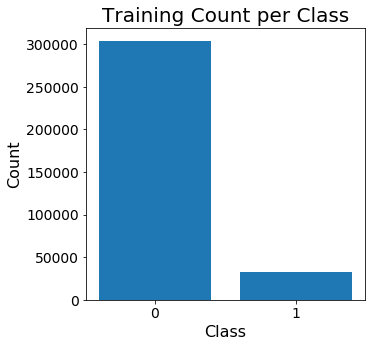

In [30]:
# visualise training class distribution
counts = training.groupby('label').count().orderBy('label')
show_as_html(counts)

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Training Count per Class', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()


In [31]:
# no resampling

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        2319
nN:        81806

TP         1294
FP         1025
FN         6840
TN         74966

precision: 0.55799914
recall:    0.15908532
accuracy:  0.90650817

auroc:     0.81608725



Sampling code is from CreditCardFraud notebook

In [36]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 6 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_downsampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)


dataset: training (downsampled)
total:   227369
counts:
   label   count    ratio
0      0  194837  0.85692
1      1   32532  0.14308

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        3991
nN:        80134

TP         2052
FP         1939
FN         6082
TN         74052

precision: 0.51415685
recall:    0.25227440
accuracy:  0.90465379

auroc:     0.81737347



In [15]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}

count_lower_bound = 4000
count_upper_bound = 160000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_resampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (resampled)
total:   117235
counts:
   label  count     ratio
0      0  84251  0.718651
1      1  32532  0.277494

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        8878
nN:        75247

TP         3680
FP         5198
FN         4454
TN         70793

precision: 0.41450777
recall:    0.45242193
accuracy:  0.88526597

auroc:     0.81615396



,label,count
0,0,83794
1,1,32532


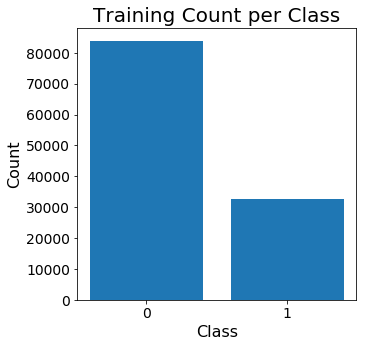

In [16]:
# visualise training class distribution after up/downsampling

counts = training_resampled.groupby('label').count().orderBy('label')
show_as_html(counts)

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Training Count per Class', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

In [37]:
# # Observation reweighting

# training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 0.1).when(F.col("label") == 1, 0.4).otherwise(1.0))

# weights = (
#     training_weighted
#     .groupBy("label")
#     .agg(
#         F.collect_set(F.col("weight")).alias("weights")
#     )
#     .toPandas()
# )
# print(weights)

# lr = LogisticRegression(featuresCol='features', labelCol='label', weightCol="weight")
# lr_model = lr.fit(training_weighted)
# pred = lr_model.transform(test)
# pred.cache()

# print_metrics(pred)

   label weights
0      0   [0.1]
1      1   [0.4]
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        9489
nN:        74636

TP         3897
FP         5592
FN         4237
TN         70399

precision: 0.41068606
recall:    0.47910007
accuracy:  0.88316196

auroc:     0.81775668



In [ ]:
training = training_resampled

#### Preprocessing

In [39]:
# standardise features training
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(training)
scaled_df = scaler_model.transform(training).select("scaledFeatures", "label")

scaled_df.show()

+--------------------+-----+
|      scaledFeatures|label|
+--------------------+-----+
|[4.75727041802046...|    0|
|[1.87806753235998...|    0|
|[1.51267912441852...|    0|
|[0.28136351634448...|    0|
|[1.22094608724787...|    0|
|[2.09412328662102...|    0|
|[3.57589603977494...|    0|
|[1.42833650377117...|    0|
|[3.41991996049558...|    0|
|[0.65134455328695...|    0|
|[1.33677276834236...|    0|
|[2.06639420586025...|    0|
|[1.25098592473871...|    0|
|[2.75673277896704...|    0|
|[2.31855553402855...|    0|
|[1.05630467023077...|    0|
|[1.51845601624368...|    0|
|[2.70907342140946...|    0|
|[2.15362527242019...|    0|
|[1.33012934274342...|    0|
+--------------------+-----+
only showing top 20 rows



In [40]:
# standardise features test
scaled_test = scaler_model.transform(test).select("scaledFeatures", "label")
scaled_test.show()

+--------------------+-----+
|      scaledFeatures|label|
+--------------------+-----+
|[3.00109530317137...|    0|
|[1.48437235447523...|    0|
|[1.65363528495246...|    0|
|[1.93237031551650...|    0|
|[0.99362539392777...|    0|
|[1.08518912935657...|    0|
|[2.03895396969073...|    0|
|[2.60335630100901...|    0|
|[2.86938216955769...|    0|
|[2.06003962485257...|    0|
|[2.88180248698179...|    1|
|[1.42891419295368...|    0|
|[1.57997991418165...|    0|
|[10.4648395412799...|    0|
|[1.68858548049469...|    0|
|[0.87259951019063...|    0|
|[1.88182251204634...|    0|
|[0.68687243801169...|    0|
|[0.85353576716760...|    0|
|[1.74953168925014...|    0|
+--------------------+-----+
only showing top 20 rows



In [41]:
# reference: https://stackoverflow.com/questions/63190529/how-to-determine-the-optimum-number-of-features-in-pca-with-pyspark
# use PCA on all 15... I've jsut realised I used 15 instead of 16 features. But, won't matter as it will still include the 
# features that explain the most variance (the first 7)

pca = PCA(k=15, inputCol="scaledFeatures", outputCol="PCA")
pcaModel = pca.fit(scaled_df)
print(pcaModel.explainedVariance) 

[0.3742788880318388,0.24323372455045655,0.11453989214009525,0.0734156834489262,0.07067456419032163,0.05068640580997903,0.03659054154082232,0.01829499656200088,0.010083163470255953,0.002968741379217174,0.0023289963080043827,0.0012960522261105684,0.0008900014882141201,0.0006722980496569623,4.6050804100243484e-05]


Text(0,0.5,'Cumulative Explained Variance')

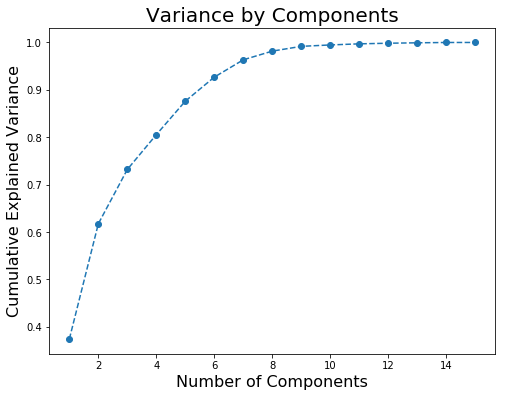

In [42]:
# plot the cumulative variance
cumValues = pcaModel.explainedVariance.cumsum()

plt.figure(figsize=(8,6))
plt.plot(range(1,16), cumValues, marker = 'o', linestyle='--')
plt.title('Variance by Components', fontsize=20)
plt.xlabel('Number of Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)

In [ ]:
# apply PCA to the training data
pca = PCA(k = 7, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(scaled_df).select(F.col("pcaFeatures").alias("features"), "label")
pca_df.cache()

In [ ]:
# apply PCA to test data
pca_test = pca_model.transform(scaled_test).select(F.col("pcaFeatures").alias("features"), "label")

In [45]:
test = pca_test
test.cache()

# run logistic regression model on preprocessed data
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(pca_df)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        637
nN:        83488

TP         365
FP         272
FN         7769
TN         75719

precision: 0.57299843
recall:    0.04487337
accuracy:  0.90441605

auroc:     0.75039742



In [46]:
# run random forest model on preprocessed data
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(pca_df)
rf_predictions = rf_model.transform(test)

In [47]:
print_metrics(rf_predictions)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        107
nN:        84018

TP         80
FP         27
FN         8054
TN         75964

precision: 0.74766355
recall:    0.00983526
accuracy:  0.90394056

auroc:     0.72967189



In [48]:
# run GBT model on preprocessed data
gbt = GBTClassifier(featuresCol="features", labelCol="label")
gbt_model = gbt.fit(pca_df)
gbt_predictions = gbt_model.transform(test)

print_metrics(gbt_predictions)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1257
nN:        82868

TP         787
FP         470
FN         7347
TN         75521

precision: 0.62609387
recall:    0.09675436
accuracy:  0.90707875

auroc:     0.79489577



### Question 4 (b)
### Multiclass Classification

In [88]:
# encode all genres

indexer = StringIndexer(inputCol="genre", outputCol="label")
indexerModel = indexer.fit(audio_features)
indexedGenres = indexerModel.transform(audio_features)

# change 'label' to integer because it was double type
all_genres = indexedGenres.withColumn("label", F.col("label").cast("integer"))

show_as_html(all_genres)

,track_id,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre,label
0,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.030,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.960,Pop_Rock,0
1,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.040,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.200,Pop_Rock,0
2,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.220,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.540,Reggae,9
3,TRAAZNZ128F429EF86,2.151,0.01510,0.002339,313.1,0.001605,0.05131,0.10450,5.716,3.000,0.01887,0.000672,1753.0,0.002109,0.07594,0.6155,7.968,Pop_Rock,0
4,TRAAZOZ12903C9CABF,9.105,0.07933,0.001464,160.0,0.001404,0.05231,0.04957,22.330,14.120,0.10410,0.001351,1606.0,0.003109,0.12470,0.5421,42.130,Pop_Rock,0
5,TRABCWK128F42BBC0B,14.390,0.13420,0.003954,164.6,0.002357,0.08090,0.05017,33.420,15.650,0.12060,0.003471,1601.0,0.004545,0.18010,0.5392,49.260,Pop_Rock,0
6,TRABGUX12903CD11FF,5.346,0.05279,0.000837,195.9,0.001113,0.03719,0.06847,16.690,3.637,0.02123,0.000449,1562.0,0.001671,0.06217,0.6083,13.950,Rap,2
7,TRABHCK128F423E15A,4.200,0.03555,0.001214,231.6,0.001317,0.04669,0.05113,11.040,8.027,0.05080,0.001104,1664.0,0.003163,0.12360,0.5095,23.290,International,6
8,TRABIRM128F92CA303,6.157,0.04623,0.004473,181.4,0.001872,0.05868,0.05181,13.710,14.520,0.11220,0.003155,1573.0,0.004639,0.18630,0.6296,41.920,Pop_Rock,0
9,TRABMLM128F429BFA2,4.991,0.03965,0.000192,232.4,0.001848,0.06943,0.09764,12.680,9.264,0.05438,0.000089,1757.0,0.001916,0.07273,0.5610,20.320,Vocal,11


In [50]:
# check counts per genre

counts = all_genres.groupby('label').count().orderBy('label')
show_as_html(counts)

,label,count
0,0,237649
1,1,40666
2,2,20899
3,3,17775
4,4,17504
5,5,14314
6,6,14194
7,7,11691
8,8,8780
9,9,6931


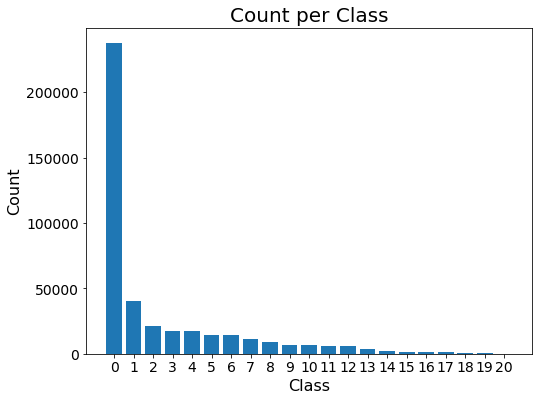

In [51]:
# visualise class distribution

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count per Class', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

In [89]:
# exclude 'id', genre' and 'label' columns from features

feature_cols = all_genres.columns[1:-3]  
print(feature_cols) # check it worked correctly

['F000', 'F001', 'F002', 'F003', 'F004', 'F005', 'F006', 'F007', 'F008', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014']


In [90]:
# create vector of features 

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(all_genres).select("features", "label")

assembled_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[5.699,0.03838,0....|    0|
|[3.267,0.02975,0....|    0|
|[13.68,0.09743,0....|    9|
|[2.151,0.0151,0.0...|    0|
|[9.105,0.07933,0....|    0|
|[14.39,0.1342,0.0...|    0|
|[5.346,0.05279,8....|    2|
|[4.2,0.03555,0.00...|    6|
|[6.157,0.04623,0....|    0|
|[4.991,0.03965,1....|   11|
|[7.441,0.06391,0....|    0|
|[6.912,0.05089,1....|    0|
|[4.54,0.03856,0.0...|    7|
|[8.601,0.07272,6....|    6|
|[8.764,0.07738,0....|    0|
|[3.006,0.0281,0.0...|    0|
|[8.711,0.0647,0.0...|    0|
|[9.714,0.07607,0....|    0|
|[7.929,0.06456,0....|    0|
|[8.168,0.05992,0....|    0|
+--------------------+-----+
only showing top 20 rows



In [54]:
print_class_balance(assembled_df, "assembled_df")

dataset: assembled_df
total:   420620
counts:
    label   count     ratio
0       0  237649  0.564997
1       1   40666  0.096681
2       2   20899  0.049686
3       3   17775  0.042259
4       4   17504  0.041615
5       5   14314  0.034031
6       6   14194  0.033745
7       7   11691  0.027795
8       8    8780  0.020874
9       9    6931  0.016478
10     10    6801  0.016169
11     11    6182  0.014697
12     12    5789  0.013763
13     13    4000  0.009510
14     14    2067  0.004914
15     15    1613  0.003835
16     16    1535  0.003649
17     17    1012  0.002406
18     18     555  0.001319
19     19     463  0.001101
20     20     200  0.000475



In [91]:
# use same stratified random smapling as before but for 21 classes
temp = (
    assembled_df
    .withColumn("num", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

assembled_df.cache()

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 237649 * 0.8)) |
    ((F.col("label") == 1) & (F.col("row") < 40666 * 0.8)) |
    ((F.col("label") == 2) & (F.col("row") < 20899 * 0.8)) |
    ((F.col("label") == 3) & (F.col("row") < 17775 * 0.8)) |
    ((F.col("label") == 4) & (F.col("row") < 17504 * 0.8)) |
    ((F.col("label") == 5) & (F.col("row") < 14314 * 0.8)) |
    ((F.col("label") == 6) & (F.col("row") < 14194 * 0.8)) |
    ((F.col("label") == 7) & (F.col("row") < 11691 * 0.8)) |
    ((F.col("label") == 8) & (F.col("row") < 8780 * 0.8)) |
    ((F.col("label") == 9) & (F.col("row") < 6931 * 0.8)) |
    ((F.col("label") == 10) & (F.col("row") < 6801 * 0.8)) |
    ((F.col("label") == 11) & (F.col("row") < 6182 * 0.8)) |
    ((F.col("label") == 12) & (F.col("row") < 5789 * 0.8)) |
    ((F.col("label") == 13) & (F.col("row") < 4000 * 0.8)) |
    ((F.col("label") == 14) & (F.col("row") < 2067 * 0.8)) |
    ((F.col("label") == 15) & (F.col("row") < 1613 * 0.8)) |
    ((F.col("label") == 16) & (F.col("row") < 1535 * 0.8)) |
    ((F.col("label") == 17) & (F.col("row") < 1012 * 0.8)) |
    ((F.col("label") == 18) & (F.col("row") < 555 * 0.8)) |
    ((F.col("label") == 19) & (F.col("row") < 463 * 0.8)) |
    ((F.col("label") == 20) & (F.col("row") < 200 * 0.8)) 
    
)
training.cache()

test = temp.join(training, on="num", how="left_anti")
test.cache()

training = training.drop("num", "random", "row")
test = test.drop("num", "random", "row")

print_class_balance(assembled_df, "assembled_df")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: assembled_df
total:   420620
counts:
    label   count     ratio
0       0  237649  0.564997
1       1   40666  0.096681
2       2   20899  0.049686
3       3   17775  0.042259
4       4   17504  0.041615
5       5   14314  0.034031
6       6   14194  0.033745
7       7   11691  0.027795
8       8    8780  0.020874
9       9    6931  0.016478
10     10    6801  0.016169
11     11    6182  0.014697
12     12    5789  0.013763
13     13    4000  0.009510
14     14    2067  0.004914
15     15    1613  0.003835
16     16    1535  0.003649
17     17    1012  0.002406
18     18     555  0.001319
19     19     463  0.001101
20     20     200  0.000475

dataset: training
total:   336483
counts:
    label   count     ratio
0       0  190119  0.565018
1       1   32532  0.096682
2       2   16719  0.049688
3       3   14219  0.042258
4       4   14003  0.041616
5       5   11451  0.034031
6       6   11355  0.033746
7       7    9352  0.027793
8       8    7023  0.020872
9       9    55

,label,count
0,0,190119
1,1,32532
2,2,16719
3,3,14219
4,4,14003
5,5,11451
6,6,11355
7,7,9352
8,8,7023
9,9,5544


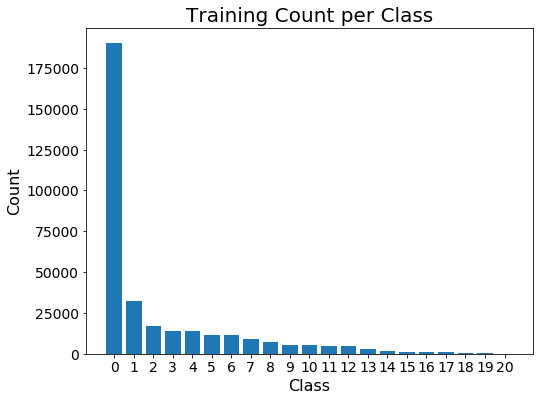

In [56]:
# visualise training class distribution

counts = training.groupby('label').count().orderBy('label')
show_as_html(counts)

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Training Count per Class', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

In [57]:
# standardise features training and test

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(training)
scaled_df = scaler_model.transform(training).select("scaledFeatures", "label")

scaled_test = scaler_model.transform(test).select("scaledFeatures", "label")

In [59]:
# Apply PCA training and test
pca = PCA(k = 7, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(scaled_df).select(F.col("pcaFeatures").alias("features"), "label")
pca_df.cache()

pca_test = pca_model.transform(scaled_test).select(F.col("pcaFeatures").alias("features"), "label")
pca_test.cache()

DataFrame[features: vector, label: int]

In [60]:
# run LR model - it will automatically determine it is binomial

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(pca_df)
pred = lr_model.transform(pca_test)
pred.cache()

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [61]:
# generate metrics
pred_label = pred.select(F.col("prediction"), F.col("label"))

# label needs to be double type to work with MulticlassMetrics
pred_label = pred_label.withColumn("label", pred_label["label"].cast(DoubleType()))

# Convert dataframe prediction, label tuples
pred_label_tuples = pred_label.select("prediction", "label").rdd.map(tuple)
metrics = MulticlassMetrics(pred_label_tuples)

In [62]:
# view confusion matrix - very hard to decipher but a lot of 0s
cm = metrics.confusionMatrix().toArray()
cm

array([[4.6304e+04, 5.7700e+02, 4.4700e+02, 3.3000e+01, 1.5000e+01,
        4.8000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 2.6000e+01,
        9.0000e+00, 4.5000e+01, 6.0000e+00, 3.0000e+00, 1.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.3690e+03, 1.1540e+03, 5.2800e+02, 9.0000e+00, 5.0000e+00,
        1.8000e+01, 2.0000e+00, 3.0000e+00, 0.0000e+00, 2.2000e+01,
        2.0000e+00, 8.0000e+00, 1.0000e+00, 4.0000e+00, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.8160e+03, 6.8200e+02, 6.6400e+02, 2.0000e+00, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.4390e+03, 2.9000e+01, 1.7000e+01, 3.7000e+01, 1.0000e+00,
        1.0000e+01, 6.0000e+00, 2.0000e+00, 0.0000e+0

In [63]:
# generate metrics

labels = pred_label.select("label").distinct().orderBy("label").rdd.map(lambda r: r[0]).collect()

# calculate precision and recall for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    class_metrics.append((label, precision, recall, f1Score))

# convert to DataFrame for better readability
metrics_df = pd.DataFrame(class_metrics, columns=["Class", "Precision", "Recall", "F1 Score"])

print(metrics_df)

    Class  Precision    Recall  F1 Score
0     0.0   0.588338  0.974206  0.733627
1     1.0   0.412290  0.141874  0.211104
2     2.0   0.327578  0.158852  0.213952
3     3.0   0.272059  0.010405  0.020043
4     4.0   0.057143  0.000571  0.001131
5     5.0   0.102941  0.004890  0.009336
6     6.0   0.000000  0.000000  0.000000
7     7.0   0.000000  0.000000  0.000000
8     8.0   0.000000  0.000000  0.000000
9     9.0   0.228916  0.013699  0.025850
10   10.0   0.055556  0.000735  0.001450
11   11.0   0.101695  0.009701  0.017712
12   12.0   0.000000  0.000000  0.000000
13   13.0   0.437500  0.008739  0.017136
14   14.0   0.000000  0.000000  0.000000
15   15.0   0.000000  0.000000  0.000000
16   16.0   0.000000  0.000000  0.000000
17   17.0   0.000000  0.000000  0.000000
18   18.0   0.000000  0.000000  0.000000
19   19.0   0.000000  0.000000  0.000000
20   20.0   0.000000  0.000000  0.000000


In [65]:
# calculate AUROC

auroc_list = []

for label in labels: # for loop using the list generated above
    binary_label_df = pred_label.withColumn( # add binary label col to treat each class as a binary problem
        "binaryLabel",
        F.when(F.col("label") == label, 1.0).otherwise(0.0) 
    )
    
    evaluator = BinaryClassificationEvaluator( # set up evaluator
        labelCol="binaryLabel",
        rawPredictionCol="prediction",
        metricName="areaUnderROC"
    )
    
    auroc = evaluator.evaluate(binary_label_df) # use evaluator on df
    auroc_list.append((label, auroc))

auroc_df = pd.DataFrame(auroc_list, columns=["Class", "AUROC"])

print(auroc_df)

    Class     AUROC
0     0.0  0.455549
1     1.0  0.583163
2     2.0  0.637327
3     3.0  0.483966
4     4.0  0.479481
5     5.0  0.524712
6     6.0  0.492783
7     7.0  0.470399
8     8.0  0.478838
9     9.0  0.531663
10   10.0  0.475886
11   11.0  0.478030
12   12.0  0.489576
13   13.0  0.492800
14   14.0  0.484918
15   15.0  0.481788
16   16.0  0.471049
17   17.0  0.487805
18   18.0  0.490864
19   19.0  0.500647
20   20.0  0.480210


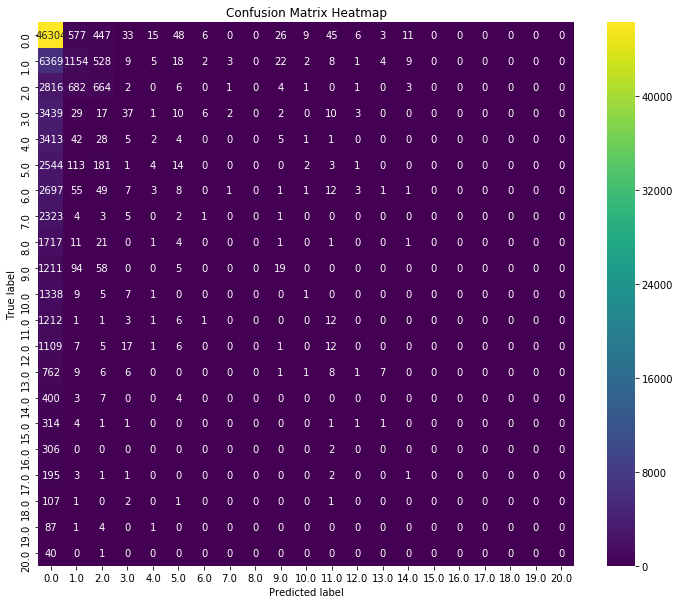

In [66]:
# visualise confusion matrix - still not good

confusion_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_df, annot=True, fmt="g", cmap="viridis")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

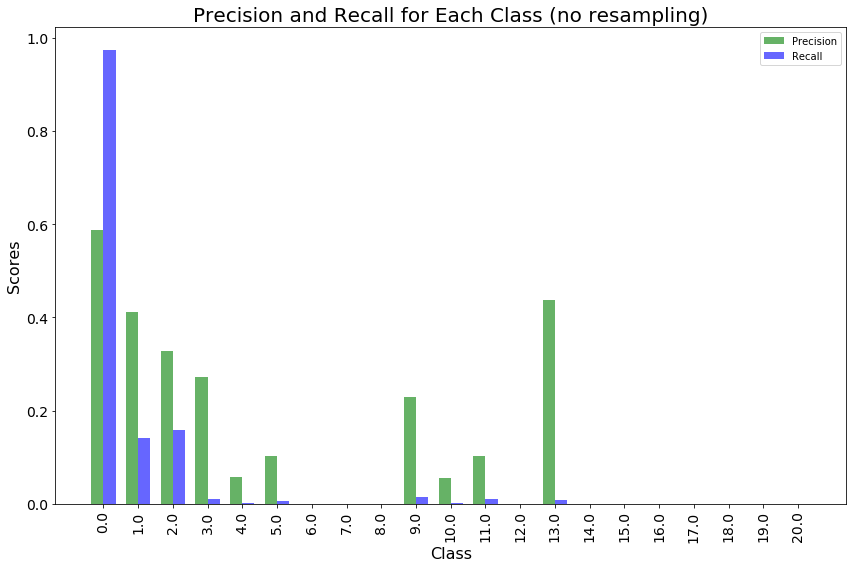

In [67]:
# visualise precision and recall

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(metrics_df))

bar1 = ax.bar(index, metrics_df["Precision"], bar_width, label='Precision', color='g', alpha=0.6)
bar2 = ax.bar(index + bar_width, metrics_df["Recall"], bar_width, label='Recall', color='b', alpha=0.6)

ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Scores', fontsize=16)
ax.set_title('Precision and Recall for Each Class (no resampling)', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_df["Class"])
ax.legend()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Try resampling to improve classification of rare classes

Using same code as above

In [92]:
temp = (
    assembled_df
    .withColumn("num", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

assembled_df.cache()

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 237649 * 0.8)) |
    ((F.col("label") == 1) & (F.col("row") < 40666 * 0.8)) |
    ((F.col("label") == 2) & (F.col("row") < 20899 * 0.8)) |
    ((F.col("label") == 3) & (F.col("row") < 17775 * 0.8)) |
    ((F.col("label") == 4) & (F.col("row") < 17504 * 0.8)) |
    ((F.col("label") == 5) & (F.col("row") < 14314 * 0.8)) |
    ((F.col("label") == 6) & (F.col("row") < 14194 * 0.8)) |
    ((F.col("label") == 7) & (F.col("row") < 11691 * 0.8)) |
    ((F.col("label") == 8) & (F.col("row") < 8780 * 0.8)) |
    ((F.col("label") == 9) & (F.col("row") < 6931 * 0.8)) |
    ((F.col("label") == 10) & (F.col("row") < 6801 * 0.8)) |
    ((F.col("label") == 11) & (F.col("row") < 6182 * 0.8)) |
    ((F.col("label") == 12) & (F.col("row") < 5789 * 0.8)) |
    ((F.col("label") == 13) & (F.col("row") < 4000 * 0.8)) |
    ((F.col("label") == 14) & (F.col("row") < 2067 * 0.8)) |
    ((F.col("label") == 15) & (F.col("row") < 1613 * 0.8)) |
    ((F.col("label") == 16) & (F.col("row") < 1535 * 0.8)) |
    ((F.col("label") == 17) & (F.col("row") < 1012 * 0.8)) |
    ((F.col("label") == 18) & (F.col("row") < 555 * 0.8)) |
    ((F.col("label") == 19) & (F.col("row") < 463 * 0.8)) |
    ((F.col("label") == 20) & (F.col("row") < 200 * 0.8)) 
    
)
training.cache()

test = temp.join(training, on="num", how="left_anti")
test.cache()

training = training.drop("num", "random", "row")
test = test.drop("num", "random", "row")

print_class_balance(assembled_df, "assembled_df")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: assembled_df
total:   420620
counts:
    label   count     ratio
0       0  237649  0.564997
1       1   40666  0.096681
2       2   20899  0.049686
3       3   17775  0.042259
4       4   17504  0.041615
5       5   14314  0.034031
6       6   14194  0.033745
7       7   11691  0.027795
8       8    8780  0.020874
9       9    6931  0.016478
10     10    6801  0.016169
11     11    6182  0.014697
12     12    5789  0.013763
13     13    4000  0.009510
14     14    2067  0.004914
15     15    1613  0.003835
16     16    1535  0.003649
17     17    1012  0.002406
18     18     555  0.001319
19     19     463  0.001101
20     20     200  0.000475

dataset: training
total:   336483
counts:
    label   count     ratio
0       0  190119  0.565018
1       1   32532  0.096682
2       2   16719  0.049688
3       3   14219  0.042258
4       4   14003  0.041616
5       5   11451  0.034031
6       6   11355  0.033746
7       7    9352  0.027793
8       8    7023  0.020872
9       9    55

In [94]:
# Ensure datasets are cached
assembled_df.cache()
training.cache()
test.cache()

DataFrame[features: vector, label: int]

In [95]:
counts = {label: count for label, count in training.groupBy("label").count().collect()}

count_lower_bound = 10000
count_upper_bound = 100000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")


dataset: training (resampled)
total:   293081
counts:
    label  count     ratio
0       0  52645  0.179626
1       1  32532  0.111000
2       2  16719  0.057046
3       3  14219  0.048516
4       4  14003  0.047779
5       5  11451  0.039071
6       6  11355  0.038744
7       7   9969  0.034014
8       8   9962  0.033991
9       9  10027  0.034212
10     10   9830  0.033540
11     11  10184  0.034748
12     12   9983  0.034062
13     13  10157  0.034656
14     14  10179  0.034731
15     15   9992  0.034093
16     16   9941  0.033919
17     17   9937  0.033905
18     18   9945  0.033933
19     19   9910  0.033813
20     20  10111  0.034499



,label,count
0,0,52615
1,1,32532
2,2,16719
3,3,14219
4,4,14003
5,5,11451
6,6,11355
7,7,9992
8,8,10023
9,9,9993


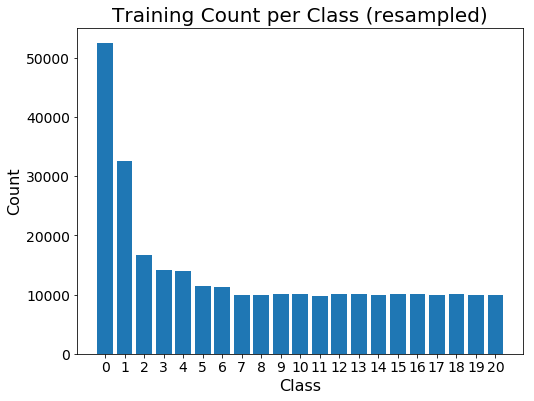

In [97]:
counts = training_resampled.groupby('label').count().orderBy('label')
show_as_html(counts)

class_count = counts.toPandas()

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(class_count["label"], class_count["count"])
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Training Count per Class (resampled)', fontsize=20)

ax.set_xticks(class_count["label"])
ax.set_xticklabels(class_count["label"])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.show()

In [71]:
# standardise features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(training_resampled)
scaled_df = scaler_model.transform(training_resampled).select("scaledFeatures", "label")
scaled_test = scaler_model.transform(test).select("scaledFeatures", "label")

# apply PCA
pca = PCA(k = 7, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(scaled_df).select(F.col("pcaFeatures").alias("features"), "label")
pca_test = pca_model.transform(scaled_test).select(F.col("pcaFeatures").alias("features"), "label")

# train model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(pca_df)

# make predictions
pred = lr_model.transform(pca_test)
pred.cache()

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [72]:
pred_label = pred.select(F.col("prediction"), F.col("label"))

pred_label = pred_label.withColumn("label", pred_label["label"].cast(DoubleType()))

pred_label_tuples = pred_label.select("prediction", "label").rdd.map(tuple)
metrics = MulticlassMetrics(pred_label_tuples)

In [73]:
auroc_list = []

for label in labels:
    binary_label_df = pred_label.withColumn(
        "binaryLabel",
        F.when(F.col("label") == label, 1.0).otherwise(0.0)
    )
    
    evaluator = BinaryClassificationEvaluator(
        labelCol="binaryLabel",
        rawPredictionCol="prediction",
        metricName="areaUnderROC"
    )

    auroc = evaluator.evaluate(binary_label_df)
    auroc_list.append((label, auroc))

auroc_df = pd.DataFrame(auroc_list, columns=["Class", "AUROC"])

print(auroc_df)

class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    class_metrics.append((label, precision, recall, f1Score))

# Convert to DataFrame for better readability
metrics_df = pd.DataFrame(class_metrics, columns=["Class", "Precision", "Recall", "F1 Score"])

# Print the metrics
print(metrics_df)

    Class     AUROC
0     0.0  0.337102
1     1.0  0.598725
2     2.0  0.666317
3     3.0  0.645042
4     4.0  0.508874
5     5.0  0.573537
6     6.0  0.564979
7     7.0  0.499494
8     8.0  0.485993
9     9.0  0.647281
10   10.0  0.501765
11   11.0  0.718469
12   12.0  0.642344
13   13.0  0.733962
14   14.0  0.693940
15   15.0  0.761765
16   16.0  0.651011
17   17.0  0.618785
18   18.0  0.766131
19   19.0  0.668806
20   20.0  0.617488
    Class  Precision    Recall  F1 Score
0     0.0   0.700101  0.745424  0.722052
1     1.0   0.247404  0.439390  0.316563
2     2.0   0.312147  0.198565  0.242726
3     3.0   0.111215  0.066648  0.083348
4     4.0   0.222482  0.027135  0.048371
5     5.0   0.119904  0.017464  0.030488
6     6.0   0.076923  0.001409  0.002767
7     7.0   0.025000  0.000428  0.000841
8     8.0   0.000000  0.000000  0.000000
9     9.0   0.153097  0.124730  0.137465
10   10.0   0.125000  0.001470  0.002905
11   11.0   0.096671  0.194826  0.129223
12   12.0   0.074527  0.057

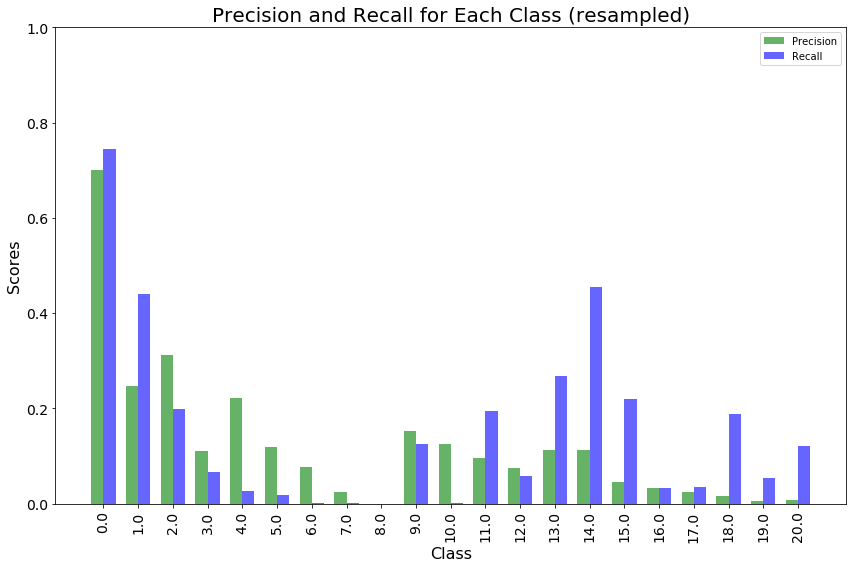

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(metrics_df))

# Plot Precision and Recall side by side
bar1 = ax.bar(index, metrics_df["Precision"], bar_width, label='Precision', color='g', alpha=0.6)
bar2 = ax.bar(index + bar_width, metrics_df["Recall"], bar_width, label='Recall', color='b', alpha=0.6)

ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('Scores', fontsize=16)
ax.set_title('Precision and Recall for Each Class (resampled)', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_df["Class"])
ax.legend()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax.set_ylim(0, 1)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Stop Spark ###

In [17]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()